# **VAE Model**

### **i. Imports and subfunctions**

In [1]:
# Imports
import copy
import torch
import tqdm
import gc
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from numba import cuda
from batchup import data_source
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision import transforms, datasets

def split_iid(dataset, n_centres):
    """ Split PyTorch dataset randomly into n_centres."""
    n_obs_per_center = [len(dataset) // n_centres for _ in range(n_centres)]
    return random_split(dataset, n_obs_per_center)

def split_per_subject(dataset, n_centres):
    pass

def federated_averaging(models, n_obs_per_client):
    """ Perform federated averaging."""
    # Error check inputs
    assert len(models) > 0
    assert len(n_obs_per_client) == len(models)

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

def loss_plot(epochs, loss, axs=False):
    """ Plot loss curve."""
    if axs:
      axs.plot(epochs, loss)
    else:
      plt.plot(epochs, loss)

def set_data_types(data_types):
    """
    Select the sensors and the mode to shape the final dataset.
    """
    sensor_data_columns = []
    for t in data_types:
        if t != "attitude":
            sensor_data_columns.append([t+".x",t+".y",t+".z"])
        else:
            sensor_data_columns.append([t+".roll", t+".pitch", t+".yaw"])
    return sensor_data_columns

def create_time_series(sensor_data_columns, activity_labels,
                       trial_codes, subject_info, 
                       mode="mag", labeled=True):
    """
    Create time series data of desired features, for chosen activities and trials.
    """
    num_data_cols = len(sensor_data_columns) if mode == "mag" else len(sensor_data_columns*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))

    for sub_id in subject_info["code"]:
        for act_id, act in enumerate(activity_labels):
            for trial in trial_codes[act]:
                csv_file = os.path.join(datadir, 'A_DeviceMotion_data',
                                        f'{act}_{trial}',
                                        f'sub_{int(sub_id)}.csv')
                raw_data = pd.read_csv(csv_file)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(sensor_data_columns):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            subject_info["weight"][sub_id-1],
                            subject_info["height"][sub_id-1],
                            subject_info["age"][sub_id-1],
                            subject_info["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data), dtype=int)
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in sensor_data_columns:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

### **ii. General setup**

In [2]:
# Directories
basedir = '~/Projects/federated_autoencoder/'
datadir = os.path.join(basedir, 'data')

# Training hyperparameters
N_ROUNDS = 10
N_CENTRES = 4
N_EPOCHS = 50
N_FEATURES = 784
BATCH_SIZE = 64
HIDDEN_DIM = 400
LATENT_DIM = 200

# Data settings
SAMPLE_RATE = 50 # Hz
FEATURE_PERIOD = 2.5 # S
TIMEPOINTS = int(FEATURE_PERIOD*SAMPLE_RATE)

# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()
    device = cuda.get_current_device()
    device.reset()

### **iii. Load data**

In [3]:
# Load data
subject_info = pd.read_csv(os.path.join(datadir, 'data_subjects_info.csv'))

# Define sensor data we want to load
sensor_data = ["rotationRate", "userAcceleration"]
sensor_data_columns = set_data_types(sensor_data)

# Define activities we are interested in
ACTIVITY_LABELS = ["sit", "std", "dws", "ups", "wlk", "jog"]
chosen_activities = ACTIVITY_LABELS[0:6]

# Choose trials to look at
TRIAL_CODES = {
    ACTIVITY_LABELS[0]:[5,13],
    ACTIVITY_LABELS[1]:[6,14],
    ACTIVITY_LABELS[2]:[1,2,11],
    ACTIVITY_LABELS[3]:[3,4,12],
    ACTIVITY_LABELS[4]:[7,8,15],
    ACTIVITY_LABELS[5]:[9,16],
}
print('Activities and trials being investigated:\n')
for key in chosen_activities:
    print(f'Activity: {key}, Trials: {TRIAL_CODES[key]}')

# Load time series
dataset = create_time_series(sensor_data_columns, chosen_activities,
                             TRIAL_CODES, subject_info,
                             mode="mag", labeled=True)
display(dataset.head())

Activities and trials being investigated:

Activity: sit, Trials: [5, 13]
Activity: std, Trials: [6, 14]
Activity: dws, Trials: [1, 2, 11]
Activity: ups, Trials: [3, 4, 12]
Activity: wlk, Trials: [7, 8, 15]
Activity: jog, Trials: [9, 16]


,rotationRate,userAcceleration,act,id,weight,height,age,gender,trial
0,0.010253,0.006959,0.0,0.0,102.0,188.0,46.0,1.0,5.0
1,0.010920,0.010673,0.0,0.0,102.0,188.0,46.0,1.0,5.0
2,0.008377,0.007010,0.0,0.0,102.0,188.0,46.0,1.0,5.0
3,0.006555,0.014892,0.0,0.0,102.0,188.0,46.0,1.0,5.0
4,0.007724,0.013001,0.0,0.0,102.0,188.0,46.0,1.0,5.0


In [4]:
# Load data into feature vectors
feature_vectors = []
labels = []

# Loop over subjects and activities and load relevant data
for uid in range(24):
    for activity in np.unique(dataset["act"]):
        activity = int(activity)
        data = dataset[(dataset["id"] == uid) & (dataset["act"] == activity)]
        acc = data["userAcceleration"].values
        rot = data["rotationRate"].values

        # Split data into features of defined length
        for i in range(0, len(data), TIMEPOINTS):
            feature_series = np.vstack((acc[i:i+125], rot[i:i+125]))
            time_steps = feature_series.shape[1]

            # Last array may require padding to be same size as others
            if time_steps != TIMEPOINTS:
                to_pad = TIMEPOINTS - time_steps
                if to_pad % 2 == 0:
                    pad_tuple = (int(to_pad/2), int(to_pad/2))
                else:
                    pad_tuple = (int(np.ceil(to_pad/2)),int(np.floor(to_pad/2)))
                feature_series = np.pad(feature_series, ((0,0),pad_tuple), 'constant')

            # Append feature array to dataset
            feature_vectors.append(feature_series)
            labels.append(activity)

# Create total dataset and load into batch
total_data = np.stack(feature_vectors)
labels = np.asarray(labels)

# Split dataset
np.random.seed(0)
split_ratio = 0.8
split_point = int(total_data.shape[0]*0.8)
indices = np.random.permutation(total_data.shape[0])
training_idx, test_idx = indices[:split_point], indices[split_point:]
training, test = total_data[training_idx,:,:], total_data[test_idx,:,:]
train_labels, test_labels = labels[training_idx], labels[test_idx]
train_ds = data_source.ArrayDataSource([training, train_labels])
train_batches = int(training.shape[0]/BATCH_SIZE)

## **1. Create models**

In [5]:
class VAE(nn.Module):
    def __init__(self,
                 seq_len=125,
                 feat_dim=2,
                 latent_dim=2,
                 hidden_layer_sizes=[100, 200],
                 lin_size=6400):
        super(VAE, self).__init__()

        # Assign variables
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.latent_dim = latent_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.lin_size = lin_size

        # Build Encoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv1d(self.feat_dim, self.hidden_layer_sizes[0], kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv1d(self.hidden_layer_sizes[0], self.hidden_layer_sizes[1], kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                )
        )

        # Build encoder
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(self.lin_size, self.latent_dim)
        self.fc_var = nn.Linear(self.lin_size, self.latent_dim)

        # Build decoder
        self.decoder_output = nn.Linear(self.latent_dim, self.lin_size)
        modules = []
        modules.append(
            nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose1d(self.hidden_layer_sizes[1], self.hidden_layer_sizes[0],
                                    kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose1d(self.hidden_layer_sizes[0], self.feat_dim,
                                    kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                )
        )
        self.decoder = nn.Sequential(*modules) 
      
    def encode(self, x):
        """ Encode input to mean and logvar."""
        # Get values from encoding features
        result = self.encoder(x)
        result = result.view(x.shape[0], -1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)

        return [mu, logvar]
    
    def reparameterise(self, mu, logvar):
        """ Reparameterise to sample."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps * std + mu

    def decode(self, z):
        """ Decode latent sampling to output."""
        result = self.decoder_output(z)
        result = result.view(z.shape[0],
                             self.hidden_layer_sizes[1], 
                             int(self.lin_size/self.hidden_layer_sizes[1]))
        result = self.decoder(result)

        return result

    def forward(self, x):
        """ Forward pass of the network."""
        # Check input length matches in_features
        # if x.shape[-1] != self.in_features:
        #     raise Exception(f'Input features must be equal to {self.in_features}!')

        # Encode input to mean and logvar
        mu, logvar = self.encode(x)

        # Reparameterise
        z = self.reparameterise(mu, logvar)

        # Decode and return values
        return [self.decode(z), x, mu, logvar]
    
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.criterion = F.mse_loss

    def forward(self, outputs, inputs, mu, logvar, Beta=5):   
        recon_loss = self.criterion(outputs, inputs, reduction='sum')
        kl = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())

        return recon_loss, kl, recon_loss + (Beta*kl)

## **2. Train VAE**

In [6]:
# Initialise model
StandardVAE = VAE().to(device)
params = sum(p.numel() for p in StandardVAE.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(StandardVAE)

# Optimiser and loss
optimizer = torch.optim.Adam(StandardVAE.parameters(), lr=1e-3)
criterion = VAELoss()

Total number of parameters is: 166406
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(2, 100, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(100, 200, kernel_size=(3,), stride=(2,), padding=(1,))
      (3): ReLU()
    )
  )
  (fc_mu): Linear(in_features=6400, out_features=2, bias=True)
  (fc_var): Linear(in_features=6400, out_features=2, bias=True)
  (decoder_output): Linear(in_features=2, out_features=6400, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ReLU()
      (1): ConvTranspose1d(200, 100, kernel_size=(3,), stride=(2,), padding=(1,))
      (2): ReLU()
      (3): ConvTranspose1d(100, 2, kernel_size=(3,), stride=(2,), padding=(1,))
      (4): ReLU()
    )
  )
)


In [7]:
# Initialise model
StandardVAE.train()
losses = {'recon': [],
          'kl': [],
          'training': []
          }
print('Beginning standard VAE training...\n')
for epoch in range(N_EPOCHS):
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_train_loss = 0.0
    with tqdm.tqdm(train_ds.batch_iterator(batch_size=BATCH_SIZE,
                                           shuffle=np.random.RandomState(12345)),
                   unit='batch', total=train_batches) as tepoch:
        for batch_idx, (batch_X, batch_y) in enumerate(tepoch):
            # Batch tensor
            batch_tensor = torch.Tensor(batch_X.astype(np.float64)).to(device)

            # Compute reconstructions
            results, x, mu, logvar = StandardVAE(batch_tensor)

            # Loss
            recon_loss, kl_loss, train_loss = criterion(results, batch_tensor,
                                                        mu=mu, logvar=logvar)

            # Backpropagation based on the loss
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Update loss
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()
            running_train_loss += train_loss.item()

            # Log
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch+1}")
                tepoch.set_postfix(loss=train_loss.item())

    # Average epoch loss
    losses['recon'].append(running_recon_loss/batch_idx+1)
    losses['kl'].append(running_kl_loss/batch_idx+1)
    losses['training'].append(running_train_loss/batch_idx+1)

Beginning standard VAE training...



Epoch 1: : 143batch [00:01, 130.70batch/s, loss=6.24e+3]                    
Epoch 2: : 143batch [00:00, 502.49batch/s, loss=6.04e+3]                   
Epoch 3: : 143batch [00:00, 509.58batch/s, loss=6.02e+3]                   
Epoch 4: : 143batch [00:00, 570.34batch/s, loss=5.47e+3]                    
Epoch 5: : 143batch [00:00, 527.18batch/s, loss=5.37e+3]                    
Epoch 6: : 143batch [00:00, 546.41batch/s, loss=5.4e+3]                     
Epoch 7: : 143batch [00:00, 603.97batch/s, loss=5.35e+3]                    
Epoch 8: : 143batch [00:00, 511.61batch/s, loss=5.5e+3]                    
Epoch 9: : 143batch [00:00, 470.68batch/s, loss=5.67e+3]                    
Epoch 10: : 143batch [00:00, 598.49batch/s, loss=5.41e+3]                    
Epoch 11: : 143batch [00:00, 568.95batch/s, loss=5.38e+3]                    
Epoch 12: : 143batch [00:00, 519.28batch/s, loss=5.35e+3]                    
Epoch 13: : 143batch [00:00, 531.62batch/s, loss=5.54e+3]                   

## **2.1 Loss curves**

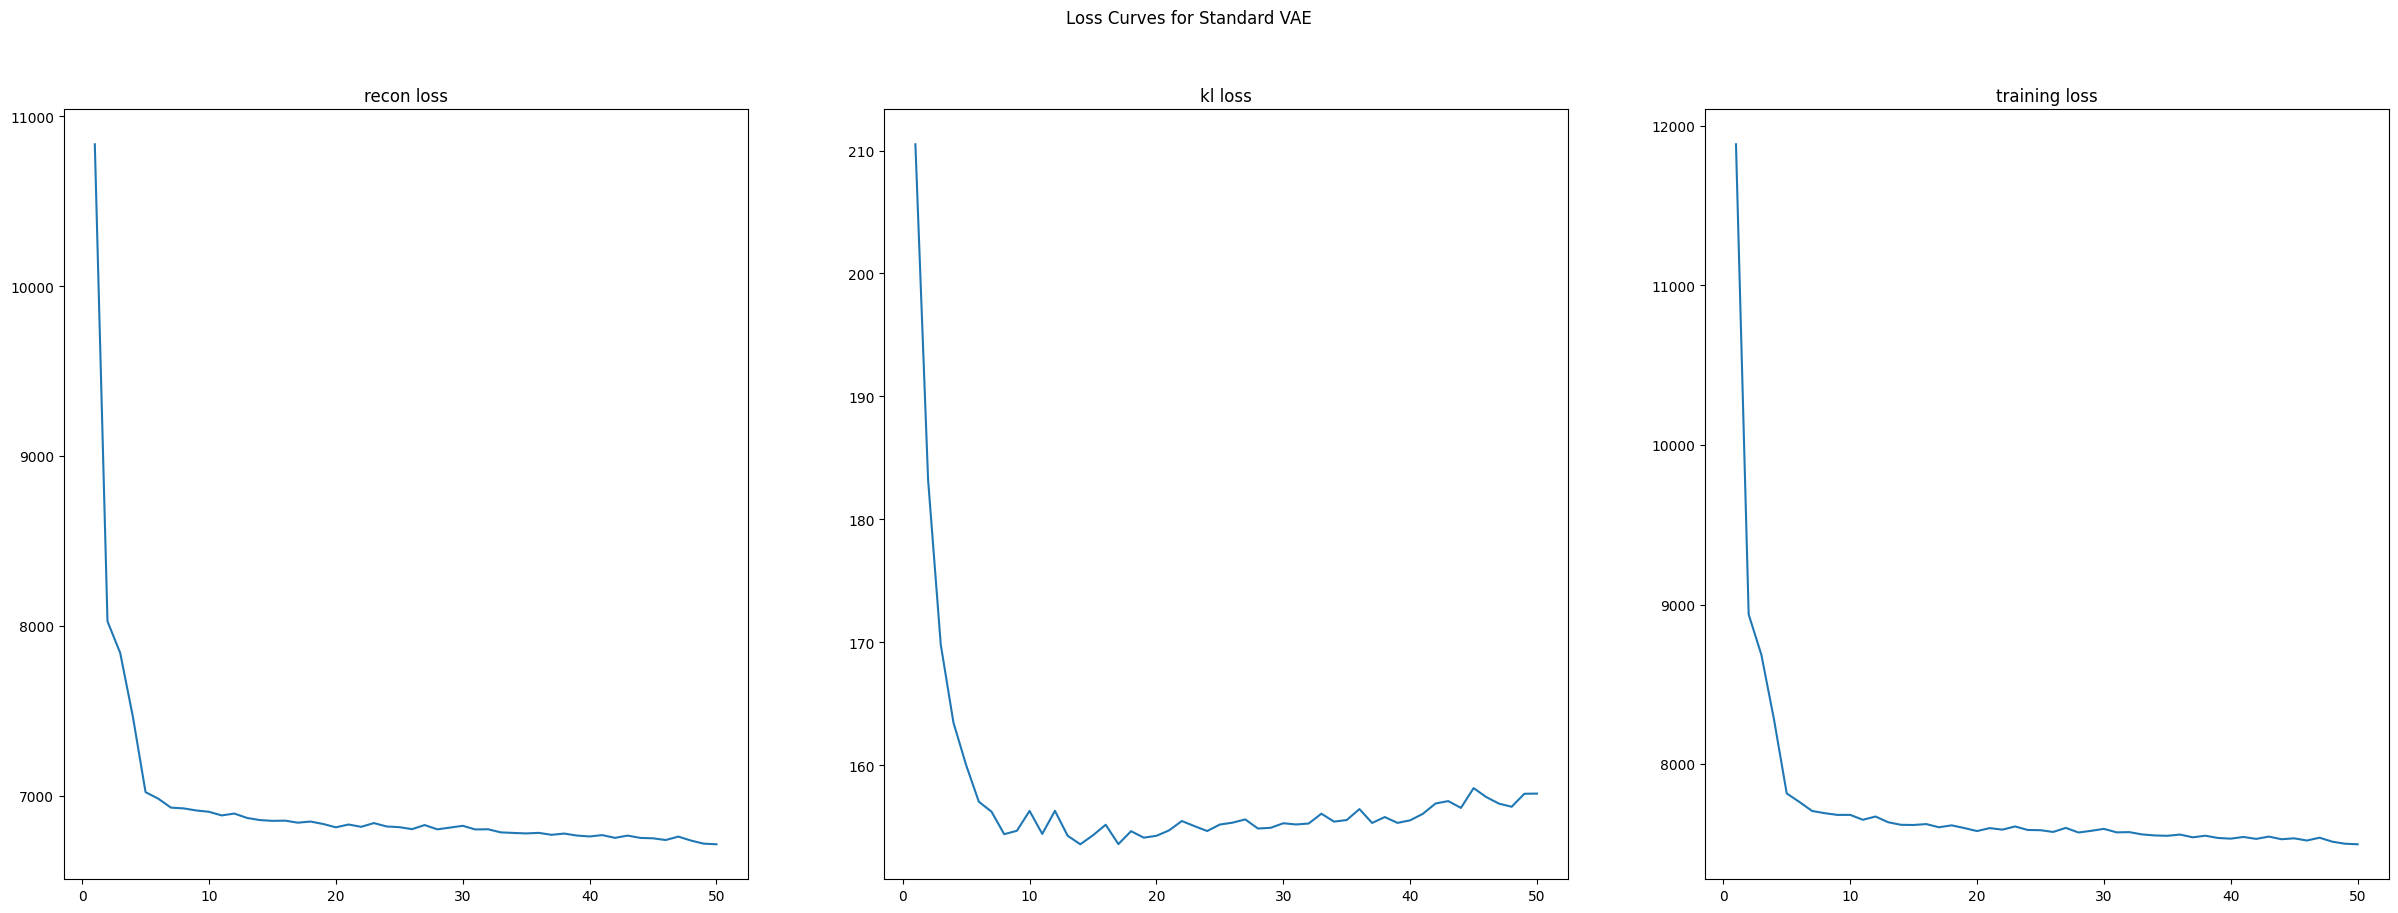

In [8]:
# Loss plots
fig, axs = plt.subplots(1,3, figsize=(30,10))
plt.suptitle("Loss Curves for Standard VAE")
for i, k in enumerate(losses):
  loss_plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), losses[k], axs=axs[i])
  axs[i].set_title(f"{k} loss")


## **3. Analyse VAE**

In [13]:
x_ticks = np.arange(0.,TIMEPOINTS/SAMPLE_RATE,1./SAMPLE_RATE)

Input time series
--------------------------------------------------


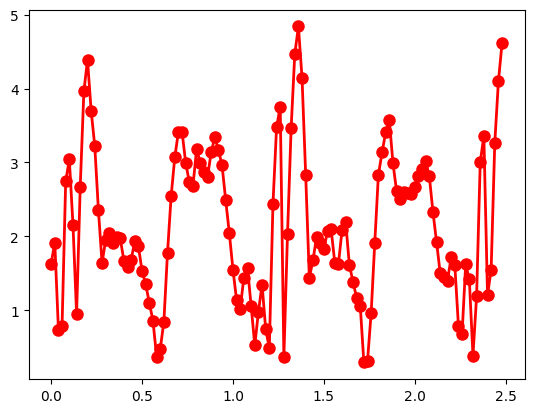

Reconstructed time series
--------------------------------------------------


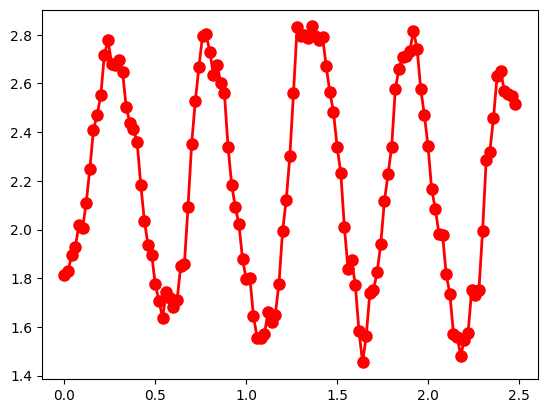

Generated time series
--------------------------------------------------


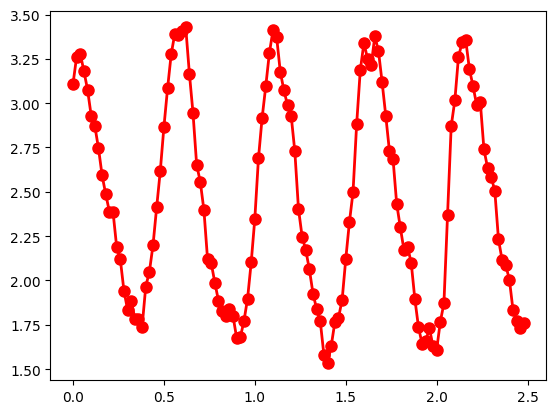

In [50]:
# Visualise original images
print('Input time series')
print('-'*50)
sample_input = test[-1]
plt.plot(x_ticks, sample_input[1], 'ro-', linewidth=2, markersize=8)
plt.show()


print('Reconstructed time series')
print('-'*50)
StandardVAE.eval()
with torch.no_grad():
    # Visualize the reconstructed images of the last batch of test set
    sample_input = torch.Tensor(sample_input).to(device)
    sample_input = sample_input[None, :, :]
    recon_output = StandardVAE(sample_input)
    recon_output = recon_output[0].cpu()
    recon_output = np.squeeze(recon_output)
    plt.plot(x_ticks, recon_output[1], 'ro-', linewidth=2, markersize=8)
    plt.show()

print('Generated time series')
print('-'*50)
StandardVAE.eval()
n_samples = 1
z = torch.randn(n_samples, 2).to(device)
with torch.no_grad():
    samples = StandardVAE.decode(z)
    samples = samples[0].cpu()
    samples = np.squeeze(samples)
    plt.plot(x_ticks, samples[1], 'ro-', linewidth=2, markersize=8)
    plt.show()


In [34]:
from sklearn.manifold import TSNE

In [43]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
pp = tsne.fit_transform(total_data.reshape(total_data.shape[0], -1))

/home/ic-ai4health-fri/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ic-ai4health-fri/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11380 samples in 0.001s...
[t-SNE] Computed neighbors for 11380 samples in 0.570s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11380
[t-SNE] Computed conditional probabilities for sample 2000 / 11380
[t-SNE] Computed conditional probabilities for sample 3000 / 11380
[t-SNE] Computed conditional probabilities for sample 4000 / 11380
[t-SNE] Computed conditional probabilities for sample 5000 / 11380
[t-SNE] Computed conditional probabilities for sample 6000 / 11380
[t-SNE] Computed conditional probabilities for sample 7000 / 11380
[t-SNE] Computed conditional probabilities for sample 8000 / 11380
[t-SNE] Computed conditional probabilities for sample 9000 / 11380
[t-SNE] Computed conditional probabilities for sample 10000 / 11380
[t-SNE] Computed conditional probabilities for sample 11000 / 11380
[t-SNE] Computed conditional probabilities for sample 11380 / 11380
[t-SNE] Mean sigma: 0.052764
[t-SNE] KL divergence

[Text(0.5, 1.0, 'aaa')]

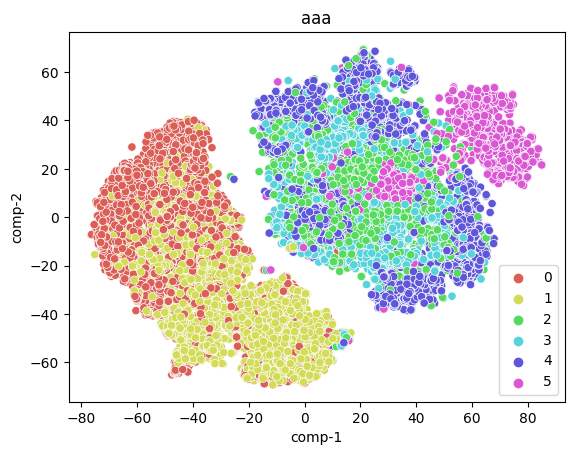

In [49]:
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = pp[:,0]
df["comp-2"] = pp[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df).set(title="aaa")